In [4]:
%matplotlib inline
import os,random

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["KERAS_FLAGS"]  = "device=gpu%d"%(0)

import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
from keras.utils import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras

In [5]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [6]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,int(n_examples)), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [7]:
from scipy import signal

def create_image_from_signal(x):
    widths = np.arange(1, 224+1)    
    r = normalize(signal.cwt(x[0], signal.ricker, widths),1)+0.5
    g = normalize(signal.cwt(x[1], signal.ricker, widths),1)+0.5
    b = (r + g)/ 2    
    rgb = np.dstack((r,g,b))
    return rgb


In [8]:
Y_train_rgb = Y_train[:3000]
X_train_rgb = np.zeros((3000,224,128,3))
for index in range(0, 3000):
    X_train_rgb[index] = create_image_from_signal(X_train[index])


In [9]:
Y_test_rgb = Y_test[:3000]
X_test_rgb = np.zeros((3000,224,128,3))
for index in range(0, 3000):
    X_test_rgb[index] = create_image_from_signal(X_test[index])


In [10]:
from keras import applications
model = applications.VGG16(include_top=False, weights='imagenet')

In [11]:
dr = 0.5 # dropout rate (%)
epochs = 50
batch_size = 16

model = models.Sequential()

model.add(Flatten(input_shape=list(X_train_rgb.shape[1:])))
model.add(Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1"))
model.add(Dropout(dr))
model.add(Dense(11, kernel_initializer="he_normal", name="dense2"))
model.add(Activation('softmax'))
model.add(Reshape([len(mods)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 86016)             0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               22020352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense2 (Dense)               (None, 11)                2827      
_________________________________________________________________
activation_1 (Activation)    (None, 11)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 11)                0         
Total params: 22,023,179
Trainable params: 22,023,179
Non-trainable params: 0
________________________________________________________________

In [12]:
top_model_weights_path = 'bottleneck_fc_model.h5'
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'

history = model.fit(
    X_train_rgb,
    Y_train_rgb,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_rgb, Y_test_rgb),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),
        keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
    ]
)

model.save_weights(top_model_weights_path)

Train on 3000 samples, validate on 3000 samples
Epoch 1/50
3000/3000 [==============================] - 65s - loss: 14.6387 - val_loss: 1.1921e-07
Epoch 2/50
3000/3000 [==============================] - 55s - loss: 14.6943 - val_loss: 1.1921e-07
Epoch 3/50
3000/3000 [==============================] - 58s - loss: 14.6890 - val_loss: 1.1921e-07
Epoch 4/50
3000/3000 [==============================] - 68s - loss: 14.7264 - val_loss: 16.1181
Epoch 5/50
3000/3000 [==============================] - 58s - loss: 14.7141 - val_loss: 16.1181
Epoch 6/50
3000/3000 [==============================] - 57s - loss: 14.7082 - val_loss: 16.1181
Epoch 7/50
3000/3000 [==============================] - 55s - loss: 14.7104 - val_loss: 16.1181


In [13]:
# Show simple version of performance
score = model.evaluate(X_test_rgb, Y_test_rgb, verbose=0, batch_size=batch_size)
print score

16.1180953979


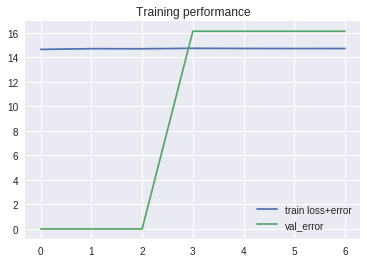

In [14]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/yoni/repos/university/ENV/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


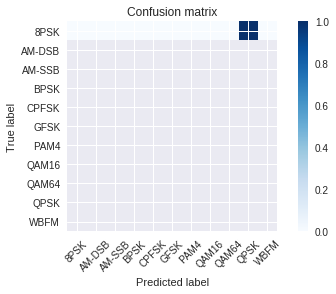

In [16]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test_rgb, batch_size=batch_size)
conf = np.zeros([len(mods),len(mods)])
confnorm = np.zeros([len(mods),len(mods)])
for i in range(0,X_test_rgb.shape[0]):
    j = list(Y_test_rgb[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(mods)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=mods)


In [17]:
# Plot confusion matrix
acc = {}
for snr in snrs:
    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test_rgb[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test_rgb[np.where(np.array(test_SNRs)==snr)]    
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

IndexError: index 10109 is out of bounds for axis 0 with size 3000

In [ ]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

In [ ]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")